In [1]:
import numpy as np
import diffrax
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax
import equinox as eqx
import sys
from scipy.stats import mode
from scipy.optimize import curve_fit
from scipy.integrate import trapz
import json
from scipy.stats import lognorm
from numpy.random import Generator, PCG64

sys.path.append("./models/")
from huang_ferrell_1996 import *
from bhalla_iyengar_1999 import *
from kholodenko_2000 import *
from levchenko_2000 import *
from brightman_fell_2000 import *
from schoeberl_2002 import *
from hatakeyama_2003 import *
from hornberg_2005 import *
from birtwistle_2007 import *
from orton_2009 import *
from vonKriegsheim_2009 import *
from shin_2014 import *
from ryu_2015 import *
from kochanczyk_2017 import *
from dessauges_2022 import *


jax.config.update("jax_enable_x64", True)
rng = Generator(PCG64())

%matplotlib inline
# plt.style.use('/home/nlinden/.matplotlib/custom.mplstyle')
plt.style.use('custom')

# custom plotting helper funcs
sys.path.insert(0, '/Users/natetest/.matplotlib/')
sys.path.insert(0, '/home/nlinden/.matplotlib/')
from plotting_helper_funcs import *
from utils import *

%env CUDA_VISIBLE_DEVICES=1


env: CUDA_VISIBLE_DEVICES=1


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def simulate_model_trajectory(model_instance, y0, params, t1=300, dt0=1e-3, n_out=1000, times=None):
    """ simulates a model over the specified time interval and returns the 
    trajectory of the model state variables."""
    ode_term = diffrax.ODETerm(model_instance)
    solver = diffrax.Kvaerno5()
    stepsize_controller = diffrax.PIDController(rtol=1e-6, atol=1e-6)
    t0 = 0.0
    dt0 = 1e-6
    if times is None:
        times = np.linspace(t0, t1, n_out)
    else:
        t1 = times[-1]
    
    saveat = saveat=diffrax.SaveAt(ts=times)

    sol = diffrax.diffeqsolve(
        ode_term, 
        solver, 
        t0, t1, dt0, 
        y0, 
        saveat=saveat, stepsize_controller=stepsize_controller,
        args=tuple(params),
        max_steps=600000,
        throw=False,)
    
    return sol

def simulate_model_steady_state(model_instance, y0, params, t1=300, dt0=1e-3, 
    event_rtol=1e-6, event_atol=1e-6):
    """ simulates a model over the specified time interval and returns the 
    calculated steady-state values."""
    ode_term = diffrax.ODETerm(model_instance)
    solver = diffrax.Kvaerno5()
    event=diffrax.SteadyStateEvent(event_rtol, event_atol)
    stepsize_controller=diffrax.PIDController(rtol=1e-6, atol=1e-6)
    t0 = 0.0
    dt0 = 1e-3

    sol = diffrax.diffeqsolve(
        ode_term, 
        solver, 
        t0, t1, dt0, 
        y0, 
        stepsize_controller=stepsize_controller,
        discrete_terminating_event=event,
        args=tuple(params),
        max_steps=None,
        throw=True,)
    
    return sol


# Generate synthetic data using the Huang and Ferrell 1996 Model

In [3]:
# run series of simulations to generate stimulus response curves
hf_1996 = huang_ferrell_1996(transient=True)
y0_dict, y0 = hf_1996.get_initial_conditions()
p_dict, plist = hf_1996.get_nominal_params()

# rescale params to make dynamics more physiological
plist = np.array(plist)

ss = []
ss_traj = []
E1_vals = np.logspace(-6.00, -3.75, 10, endpoint=False)
times = np.linspace(0, 30*60, 240) # note model is in seconds
print(E1_vals)
for i, E1 in enumerate(E1_vals):
    # update params with new stimulus
    y0_dict['E1'] = E1
    y0 = tuple([y0_dict[k] for k in y0_dict.keys()])
    # run to steady-state
    sol = simulate_model_steady_state(hf_1996, y0, plist, t1=1000, event_rtol=1e-10, event_atol=1e-10)
    sol_traj = simulate_model_trajectory(hf_1996, y0, plist, times=times)
    ss.append(sol)
    ss_traj.append(sol_traj)

# process results
pred_mapk = np.array([s.ys[-1]+s.ys[-2] for s in ss])

[1.00000000e-06 1.67880402e-06 2.81838293e-06 4.73151259e-06
 7.94328235e-06 1.33352143e-05 2.23872114e-05 3.75837404e-05
 6.30957344e-05 1.05925373e-04]


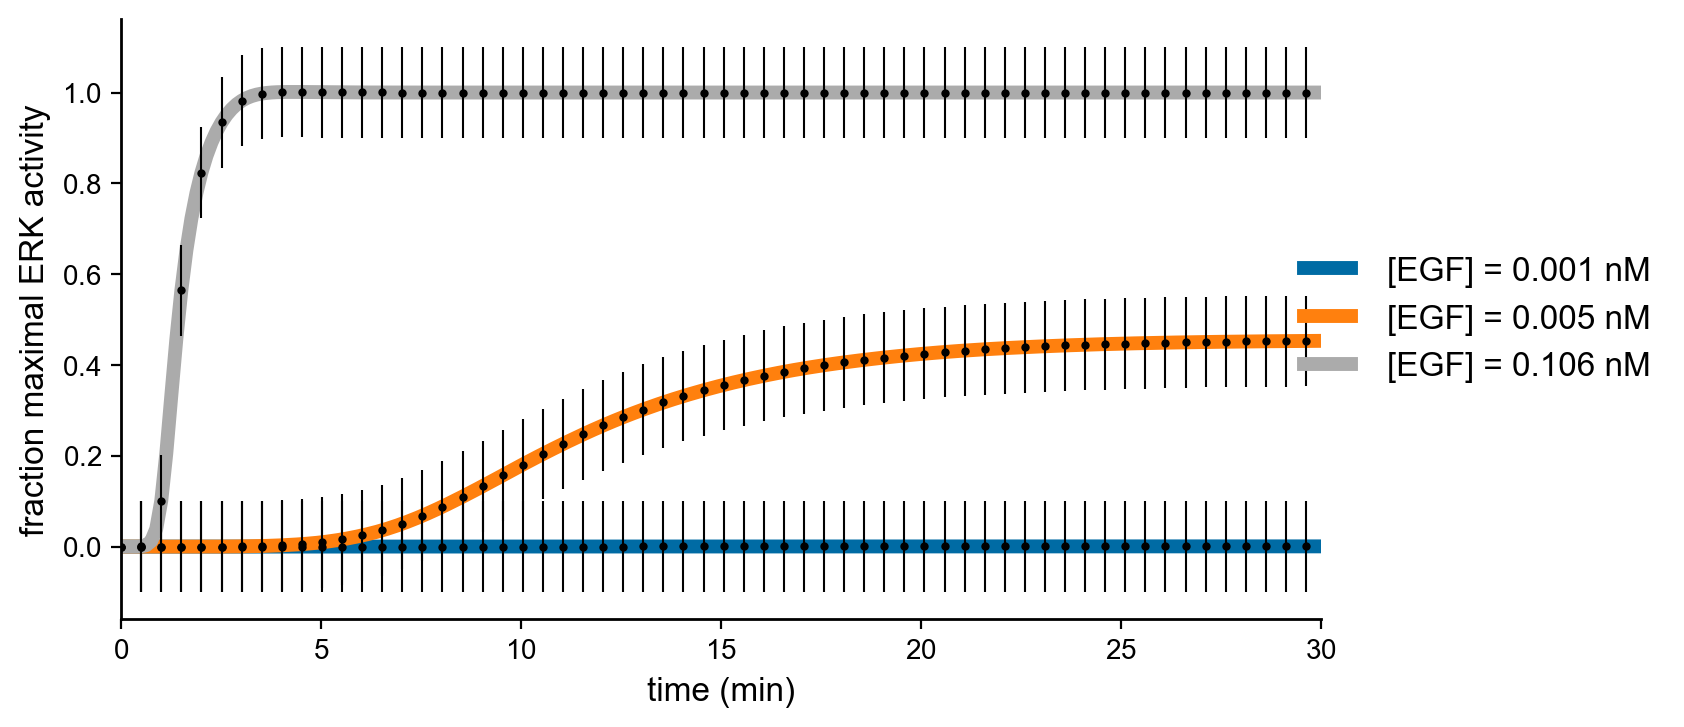

In [4]:
fig, ax = get_sized_fig_ax(6.0, 3.0)

errors = []

# error percentage
error_strength = 0.1

val_list = []
error_list = []

for i in [0,3,-1]:
    vals = (ss_traj[i].ys[-1]+ss_traj[i].ys[-2])/pred_mapk[-1]
    val_list.append(list(np.array(vals)))

    # compute error
    error = error_strength*np.ones_like(vals)
    error_list.append(list(np.array(error)))

    ax.plot(ss_traj[i].ts/60, vals, label='[EGF] = {:.3f} nM'.format(1000*E1_vals[i]), linewidth=5.0)
    ax.errorbar(ss_traj[i].ts[::4]/60, vals[::4], error[::4], fmt='o', markersize=2, color='k', linewidth=0.75)

    # save traj data
    df = pd.DataFrame({'stimulus': 1000*E1_vals[i], 'response': vals, 'time': times, 'response_std': error})
    df.to_csv('../../results/MAPK/HF_96_traj_EGF_{:.3f}.csv'.format(1000*E1_vals[i]), index=False)

ax.set_xlabel('time (min)')
ax.set_ylabel('fraction maximal ERK activity')
ax.set_xlim([0.0,max(times)/60])
ax.legend(loc='right', bbox_to_anchor=(1.3,0.5))

In [5]:
# save all data at once
# save traj data
data = {'stimulus': [1000*E1_vals[i] for i in [0,3,-1]], 'response': np.array(val_list)[:,::4].tolist(), 'time': times[::4].tolist(), 'response_std': np.array(error_list)[:, ::4].tolist()}
with open('../../results/MAPK/HF_96_traj_data.json','w') as data_file:
    json.dump(data, data_file)

### Save trajectories

In [6]:
# process results
erk_acts = []
for i in range(len(ss_traj)):
    erk_acts.append([ss_traj[i].ys[-1]+ss_traj[i].ys[-2]])
erk_acts = np.array(erk_acts)

np.save('../../results/MAPK/HF_96_trajs.npy', erk_acts)
np.save('../../results/MAPK/HF_96_traj_times.npy', np.linspace(0, 1000, 1000))

### Now normalize to the maximum response

$$
\frac{{\rm Response}}{{\rm Response}_{\rm max}}
$$

Assume noise with a standard deviation of $0.1$.

**Note the below dose-response data is with the nominal params given in the huang_ferrell_1996..py file**

(10,)


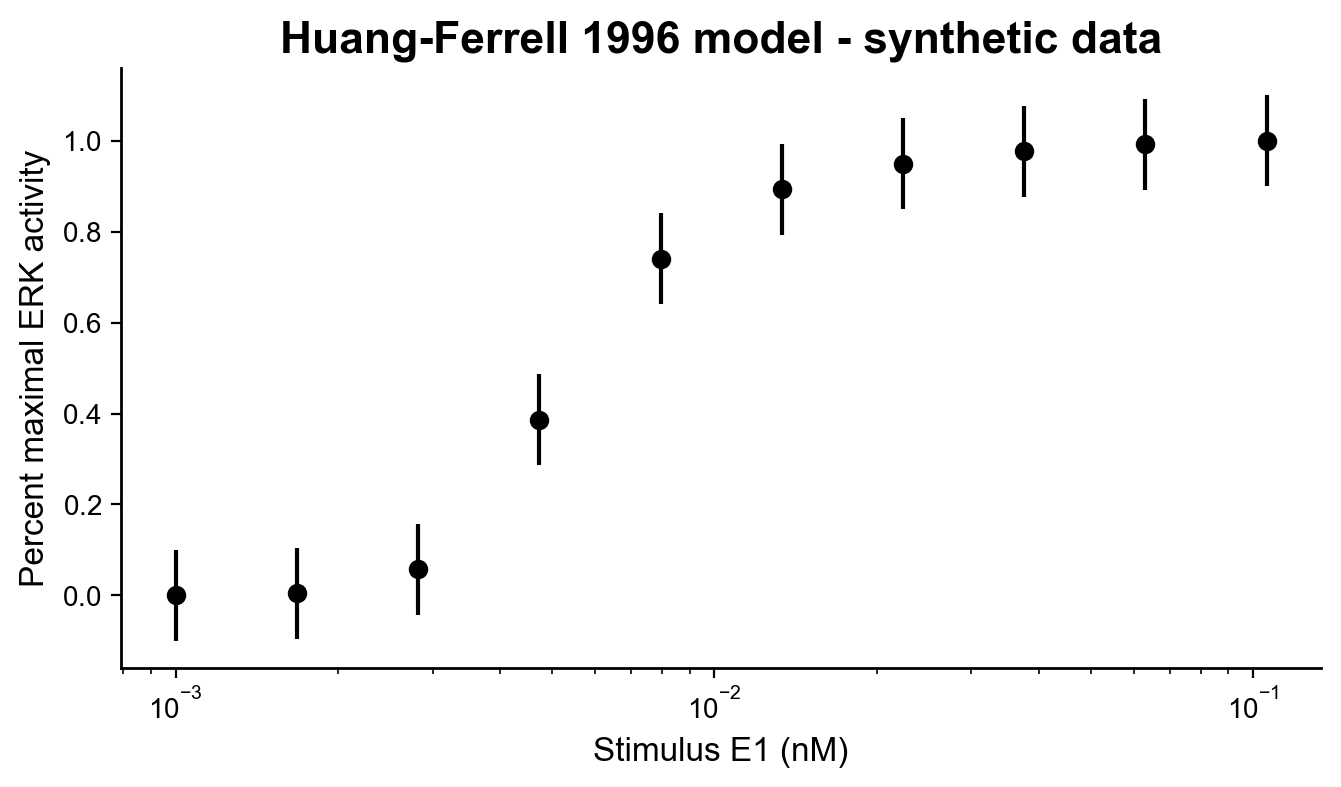

In [7]:
fig, ax = get_sized_fig_ax(6.0, 3.0)
errors = 0.1*np.squeeze(np.ones_like(pred_mapk))
errors.shape
print(E1_vals.shape)
ax.errorbar(1000*E1_vals, np.squeeze(pred_mapk)/pred_mapk[-1], yerr=errors, color='k', label='MAPKKK', fmt='o')
ax.set_xlabel('Stimulus E1 (nM)')
ax.set_ylabel('Percent maximal ERK activity')
ax.set_xscale('log')
ax.set_title('Huang-Ferrell 1996 model - synthetic data')
fig.savefig('../../figures/MAPK/HF_96_synthetic_data.pdf', bbox_inches='tight', transparent=True)

### Export the stimulus response curve to use for inference

In [8]:
# PERCENT MAXIMAL ACTIVITY
normalized_stim_resp = np.squeeze(pred_mapk)/pred_mapk[-1]
stimulus_vals_nM = 1000*E1_vals

# save data
df = pd.DataFrame({'stimulus': stimulus_vals_nM, 'response': normalized_stim_resp})
df.to_csv('../../results/MAPK/HF_96_synthetic_data.csv', index=False)

# PERCENT TOTAL MAPK ACTIVCE
normalized_stim_resp = np.squeeze(pred_mapk)/hf_1996.get_total_ERK(plist, y0)
stimulus_vals_nM = 1000*E1_vals

# save data
df = pd.DataFrame({'stimulus': stimulus_vals_nM, 'response': normalized_stim_resp})
df.to_csv('../../results/MAPK/HF_96_synthetic_data_TotalMAPKnorm.csv', index=False)

# Generate Synthetic data from XYZ MODEL

# Process data from Santos 2007

In [9]:
means = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2C.csv')
EGF_0 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_0.csv')
EGF_0_001 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_0_001.csv')
EGF_0_01 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_0_01.csv')
EGF_0_1 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_0_1.csv')
EGF_1 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_1.csv')
EGF_3 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_3.csv')
EGF_5 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_5.csv')
EGF_10 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_1.csv')
EGF_30 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_30.csv')
EGF_50 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_50.csv')
EGF_100 = pd.read_csv('../../results/MAPK/Santos_2007_Fig_2A_EGF_10.csv')

### Explore the raw data

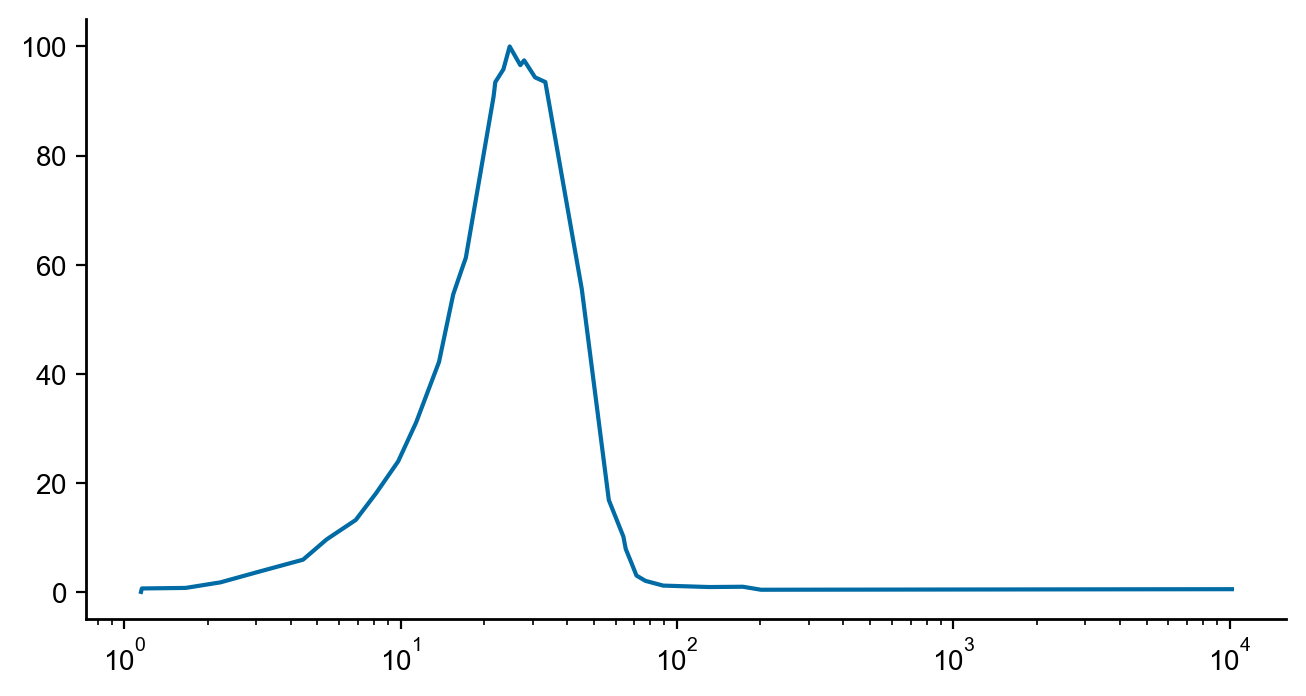

In [10]:
fig, ax = get_sized_fig_ax(6.0, 3.0)
# ax.plot(EGF_0['x'], EGF_0[' y'], label='EGF=0')
# ax.plot(EGF_0_001['x'], EGF_001[' y'], label='EGF=0.001')
# ax.plot(EGF_0_01['x'], EGF_01[' y'], label='EGF=0.01')
# ax.plot(EGF_0_1['x'], EGF_0_1[' y'], label='EGF=0.1')
# ax.plot(EGF_1['x'], EGF_1[' y'], label='EGF=1')
# ax.plot(EGF_3['x'], EGF_3[' y'], label='EGF=3')
# ax.plot(EGF_5['x'], EGF_5[' y'], label='EGF=5')
# ax.plot(EGF_10['x'], EGF_10[' y'], label='EGF=10')
# ax.plot(EGF_30['x'], EGF_30[' y'], label='EGF=30')
# ax.plot(EGF_50['x'], EGF_50[' y'], label='EGF=50')
ax.plot(EGF_100['x'], EGF_100[' y'], label='EGF=100')
ax.set_xscale('log')

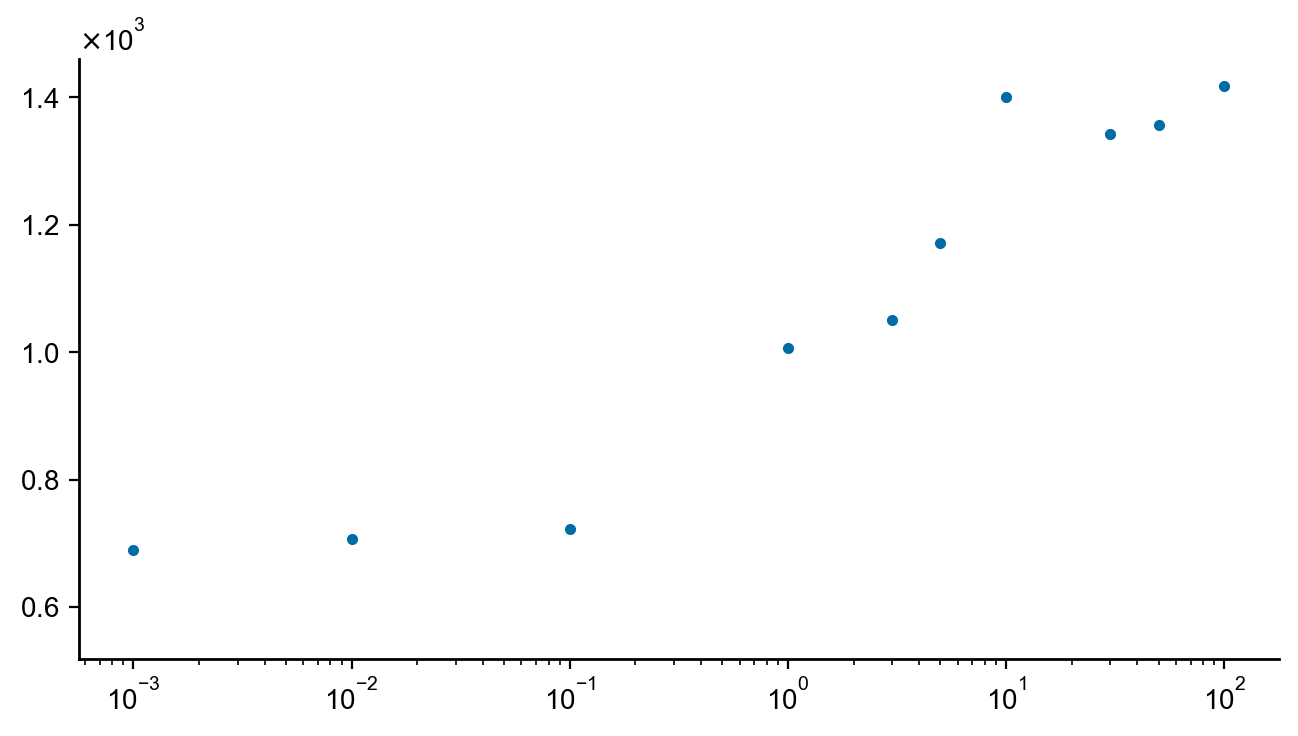

In [11]:
fig, ax = get_sized_fig_ax(6.0, 3.0)
ax.plot(means['EGF (ng/ml)'], means['ppERK1/2 (a.u.)'], '.')
ax.set_xscale('log')

[3.24409302 0.48179623]
[1.65892647 0.44416554]
[2.85226081 0.51091952]


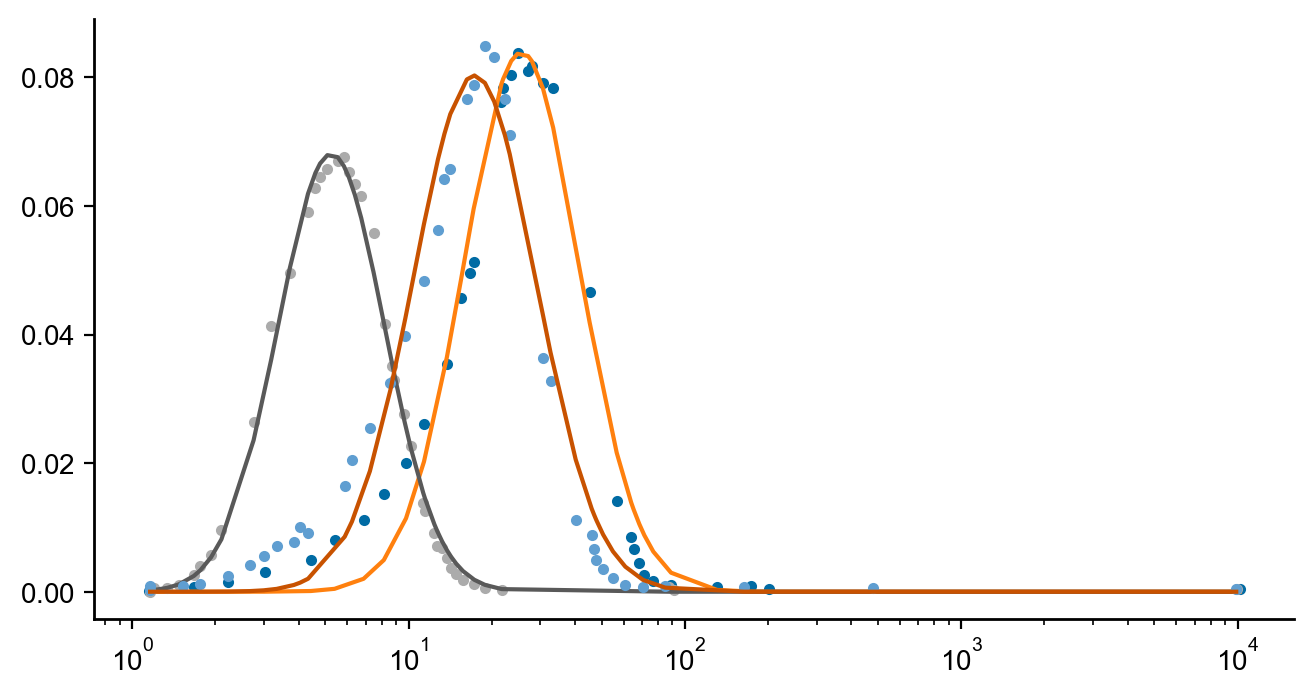

In [12]:
lognorm_pdf = lambda x, mu, sigma: 1/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(2*sigma**2))/trapz(1/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(2*sigma**2)))
norm_pdf = lambda x, mu, sigma: 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))/trapz(1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2)))

results = curve_fit(norm_pdf, np.log(EGF_100['x']), EGF_100[' y']/trapz(EGF_100[' y']), p0=[2.5, 1], maxfev=10000)
print(results[0])
fig, ax = get_sized_fig_ax(6.0, 3.0)
ax.plot(EGF_100['x'], EGF_100[' y']/trapz(EGF_100[' y']), '.')
ax.plot(EGF_100['x'], norm_pdf(np.log(EGF_100['x']), *results[0])/trapz(norm_pdf(np.log(EGF_100['x']), *results[0])))

results = curve_fit(norm_pdf, np.log(EGF_0_001['x']), EGF_0_001[' y']/trapz(EGF_0_001[' y']), p0=[2.5, 1], maxfev=10000)
print(results[0])
ax.plot(EGF_0_001['x'], EGF_0_001[' y']/trapz(EGF_0_001[' y']), '.')
ax.plot(EGF_0_001['x'], norm_pdf(np.log(EGF_0_001['x']), *results[0])/trapz(norm_pdf(np.log(EGF_0_001['x']), *results[0])))

results = curve_fit(norm_pdf, np.log(EGF_5['x']), EGF_5[' y']/trapz(EGF_5[' y']), p0=[2.5, 1], maxfev=10000)
print(results[0])
ax.plot(EGF_5['x'], EGF_5[' y']/trapz(EGF_5[' y']), '.')
ax.plot(EGF_5['x'], norm_pdf(np.log(EGF_5['x']), *results[0])/trapz(norm_pdf(np.log(EGF_5['x']), *results[0])))
ax.set_xscale('log')


In [13]:
lognorm_pdf = lambda x, mu, sigma: 1/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(2*sigma**2))/trapz(1/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(2*sigma**2)))

results_0 = curve_fit(lognorm_pdf, EGF_0['x'], EGF_0[' y']/trapz(EGF_0[' y']), p0=[2.5, 1], maxfev=10000)
var_0 = lognorm(s=results_0[0][1], scale=np.exp(results_0[0][0])).var()
results_0_001 = curve_fit(lognorm_pdf, EGF_0_001['x'], EGF_0_001[' y']/trapz(EGF_0_001[' y']), p0=[2.5, 1], maxfev=10000)
var_0_001 = lognorm(s=results_0_001[0][1], scale=np.exp(results_0_001[0][0])).var()
results_0_01 = curve_fit(lognorm_pdf, EGF_0_01['x'], EGF_0_01[' y']/trapz(EGF_0_01[' y']), p0=[2.5, 1], maxfev=10000)
var_0_01 = lognorm(s=results_0_01[0][1], scale=np.exp(results_0_01[0][0])).var()
results_0_1 = curve_fit(lognorm_pdf, EGF_0_1['x'], EGF_0_1[' y']/trapz(EGF_0_1[' y']), p0=[2.5, 1], maxfev=10000)
var_0_1 = lognorm(s=results_0_1[0][1], scale=np.exp(results_0_1[0][0])).var()
results_1 = curve_fit(lognorm_pdf, EGF_1['x'], EGF_1[' y']/trapz(EGF_1[' y']), p0=[2.5, 1], maxfev=10000)
var_1 = lognorm(s=results_1[0][1], scale=np.exp(results_1[0][0])).var()
results_3 = curve_fit(lognorm_pdf, EGF_3['x'], EGF_3[' y']/trapz(EGF_3[' y']), p0=[2.5, 1], maxfev=10000)
var_3 = lognorm(s=results_3[0][1], scale=np.exp(results_3[0][0])).var()
results_5 = curve_fit(lognorm_pdf, EGF_5['x'], EGF_5[' y']/trapz(EGF_5[' y']), p0=[2.5, 1], maxfev=10000)
var_5 = lognorm(s=results_5[0][1], scale=np.exp(results_5[0][0])).var()
results_10 = curve_fit(lognorm_pdf, EGF_10['x'], EGF_10[' y']/trapz(EGF_10[' y']), p0=[2.5, 1], maxfev=10000)
var_10 = lognorm(s=results_10[0][1], scale=np.exp(results_10[0][0])).var()
results_30 = curve_fit(lognorm_pdf, EGF_30['x'], EGF_30[' y']/trapz(EGF_30[' y']), p0=[2.5, 1], maxfev=10000)
var_30 = lognorm(s=results_30[0][1], scale=np.exp(results_30[0][0])).var()
results_50 = curve_fit(lognorm_pdf, EGF_50['x'], EGF_50[' y']/trapz(EGF_50[' y']), p0=[2.5, 1], maxfev=10000)
var_50 = lognorm(s=results_50[0][1], scale=np.exp(results_50[0][0])).var()
results_100 = curve_fit(lognorm_pdf, EGF_100['x'], EGF_100[' y']/trapz(EGF_100[' y']), p0=[2.5, 1], maxfev=10000)
var_100 = lognorm(s=results_100[0][1], scale=np.exp(results_100[0][0])).var()

### Now normalize to the maximum response

$$
\frac{{\rm Response}}{{\rm Response}_{\rm max}}
$$

Assume noise with a standard deviation of $0.1$.

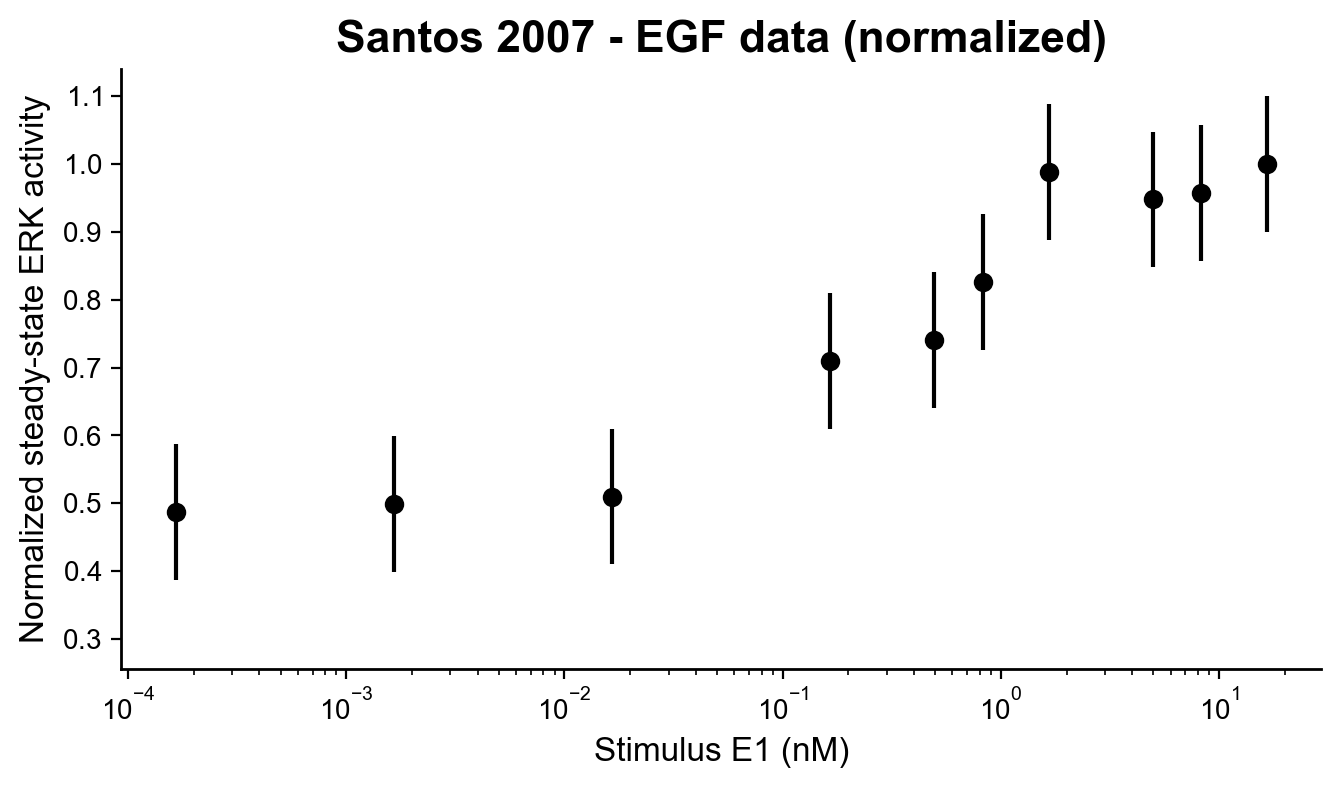

In [14]:
fig, ax = get_sized_fig_ax(6.0, 3.0)
ng_ml_nM_convert = 6.048
# errors = np.array([var_0, var_0_001, var_0_01, var_0_1, var_1, var_3, var_5, var_10, var_30, var_50, var_100])
errors = 0.1*np.ones_like(means['EGF (ng/ml)'])
ax.errorbar(means['EGF (ng/ml)']/ng_ml_nM_convert, means['ppERK1/2 (a.u.)']/np.max(means['ppERK1/2 (a.u.)']), yerr=errors, color='k', label='MAPKKK', fmt='o')
ax.set_xlabel('Stimulus E1 (nM)')
ax.set_ylabel('Normalized steady-state ERK activity')
ax.set_xscale('log')
ax.set_title('Santos 2007 - EGF data (normalized)')
fig.savefig('../../figures/MAPK/Santos_2007_data.pdf', bbox_inches='tight', transparent=True)

In [15]:
normalized_stim_resp = means['ppERK1/2 (a.u.)']/np.max(means['ppERK1/2 (a.u.)'])
stimulus_vals_nM = means['EGF (ng/ml)']/ng_ml_nM_convert

# save data
df = pd.DataFrame({'stimulus': stimulus_vals_nM, 'response': normalized_stim_resp})
df.to_csv('../../results/MAPK/Santos_2007_stim_resp_data.csv', index=False)

### Now renormalize the data but rather than normalizing to the maximum value, normalize with:

$$
\frac{{\rm Response} - {\rm Response}_{\rm min}}{{\rm Response}_{\rm max} - {\rm Response}_{\rm min}}
$$

Also, we will exclude the data point at 0 EGF concentration.

We assume noise with a standard deviation of $0.1 \times {\rm Response}$, this is an additive noise where the level depends on the level of the response

In [16]:
resps = np.array(means['ppERK1/2 (a.u.)'])[1:]
normalized = (resps - resps.min()) / (resps.max() - resps.min())

# save data
df = pd.DataFrame({'stimulus': stimulus_vals_nM[1:], 'response': normalized})
df.to_csv('../../results/MAPK/Santos_2007_stim_resp_deltaNORM_data.csv', index=False)

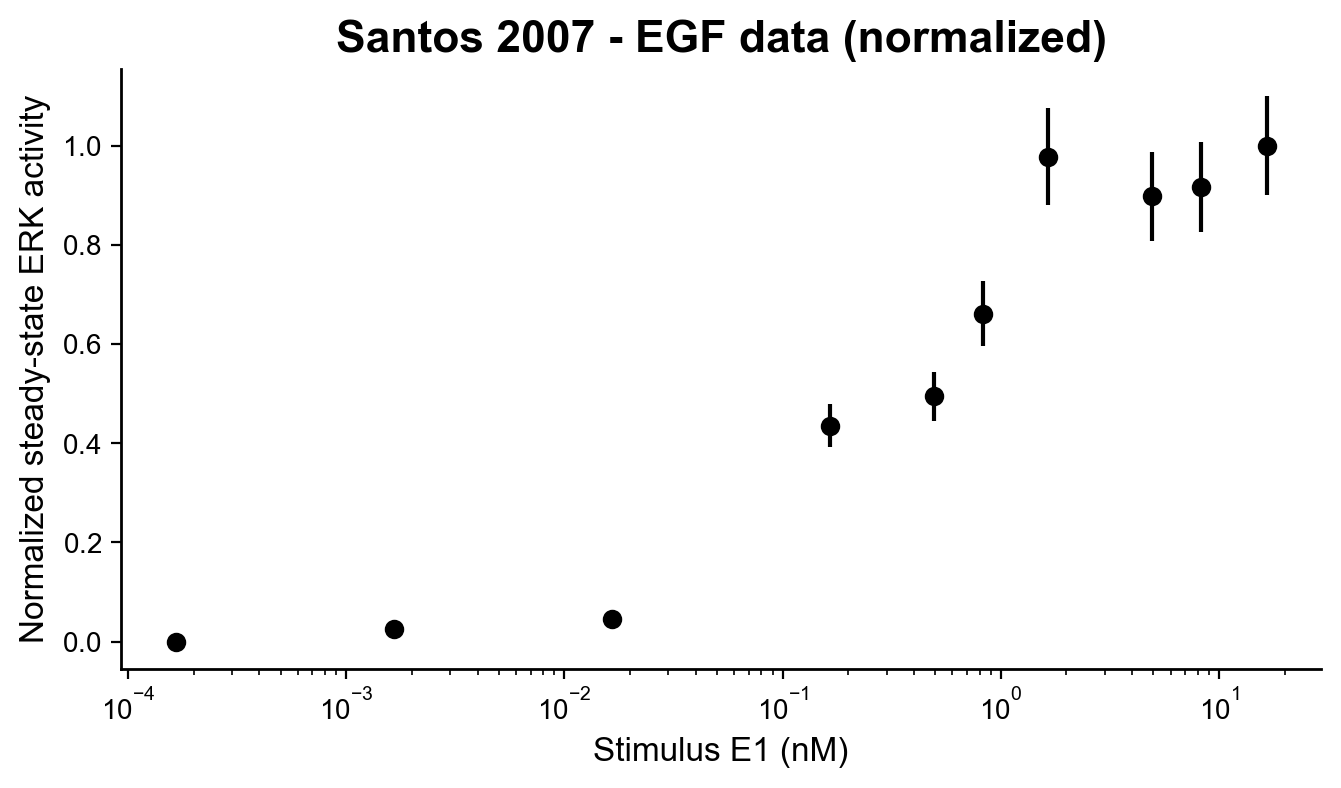

In [17]:
fig, ax = get_sized_fig_ax(6.0, 3.0)
ng_ml_nM_convert = 6.048
# errors = np.array([var_0, var_0_001, var_0_01, var_0_1, var_1, var_3, var_5, var_10, var_30, var_50, var_100])
errors = 0.1*np.ones_like(means['EGF (ng/ml)'][1:])
ax.errorbar((means['EGF (ng/ml)']/ng_ml_nM_convert)[1:], normalized, yerr=errors*normalized, color='k', label='MAPKKK', fmt='o')
ax.set_xlabel('Stimulus E1 (nM)')
ax.set_ylabel('Normalized steady-state ERK activity')
ax.set_xscale('log')
ax.set_title('Santos 2007 - EGF data (normalized)')
fig.savefig('../../figures/MAPK/Santos_2007_deltaNORM_data.pdf', bbox_inches='tight', transparent=True)

# Process Data from Keyes et al. 2020

Figure 1 - C (Cytoplasm) and D (Plasma Membrane)

In [3]:
df_1C = pd.read_excel('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2.xlsx', sheet_name='Figure 1C', 
                      skiprows=2)
df_1D = pd.read_excel('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2.xlsx', sheet_name='Figure 1D',
                      skiprows=1)     

In [4]:
input = 1.653e4 # nM EGF

Cytoplasm

8
8


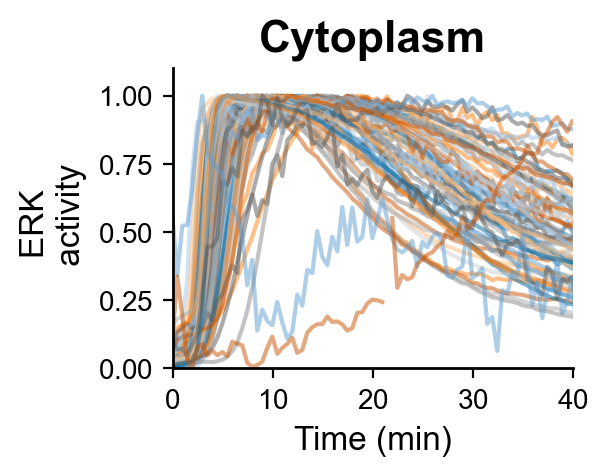

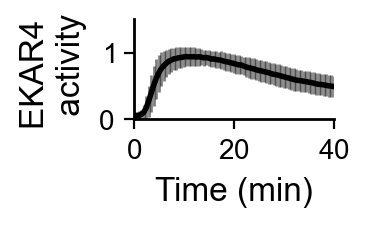

In [5]:
from matplotlib.patches import Rectangle
times = df_1C['Time (min)'].to_numpy()
times_C = times.copy()
filtered_columns = [col for col in df_1C.columns if 'Cell' in col and '.1' not in col]
C_noInhib = df_1C[filtered_columns].to_numpy()

# normalize each cell's response
normalize = lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x))
normalized_C_noInhib = np.apply_along_axis(normalize, axis=0, arr=C_noInhib)

# save to numpy
T0_idx = np.where(times==0)[0][0]
print(T0_idx)

np.savez('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-CYTO_normalized.npz', data=normalized_C_noInhib[T0_idx:np.min(np.where(np.isnan(times)))], time=times[T0_idx:np.min(np.where(np.isnan(times)))])

cyto_mean = np.nanmean(normalized_C_noInhib, axis=1)
cyto_std = np.nanstd(normalized_C_noInhib, axis=1)

T0_idx = np.where(times==0)[0][0]
print(T0_idx)

# Create dataset that end at 20 minutes and 10 mins
idx_30_min = np.argmin(abs(times[:np.min(np.where(np.isnan(times)))]-30))
idx_20_min = np.argmin(abs(times[:np.min(np.where(np.isnan(times)))]-20))
idx_10_min = np.argmin(abs(times[:np.min(np.where(np.isnan(times)))]-10))

fig, ax = get_sized_fig_ax(2.0, 1.5)
ax.plot(times, normalized_C_noInhib, alpha=0.5)
# ax.errorbar(times, cyto_mean, yerr=cyto_std, color='k', linewidth=1)
# ax.plot(times, cyto_mean,  color='k', linewidth=3)
# ax.plot([times[T0_idx]]*2, [0,1], color='r', linewidth=3)
ax.set_xlabel('Time (min)')
ax.set_ylabel('ERK \n activity')
ax.set_title('Cytoplasm')
ax.set_xlim([0, 40])
ax.set_ylim([0, 1.1])

fig.savefig('../../results/MAPK/param_est/Keyes_et_al_2020-fig1-data1-v2-CYTO.pdf', bbox_inches='tight', transparent=True)


fig, ax = get_sized_fig_ax(1.0, 0.5)

# rect = Rectangle((30, 0), 9.5, 1, facecolor='r', edgecolor='r', linewidth=1, alpha=0.25)
# ax.add_patch(rect)

# rect = Rectangle((30, 0), 10, 1, facecolor='none', edgecolor='r', linewidth=1)
# ax.add_patch(rect)

# ax.plot(times[:idx_10_min], normalized_C_noInhib[:idx_10_min], alpha=0.5)
# ax.errorbar(times[:idx_30_min], cyto_mean[:idx_30_min], yerr=cyto_std[:idx_30_min], color='k', linewidth=1, alpha=0.5)
# ax.plot(times[:idx_30_min], cyto_mean[:idx_30_min],  color='k', linewidth=2)
ax.errorbar(times, cyto_mean, yerr=cyto_std, color='k', linewidth=1, alpha=0.5)
ax.plot(times, cyto_mean,  color='k', linewidth=2)

# ax.plot([times[T0_idx]]*2, [0,1], color='r', linewidth=3)
ax.set_xlabel('Time (min)')
ax.set_ylabel('EKAR4 \n activity')
# ax.set_title('Cytoplasm')
ax.set_xticks([0, 20, 40])
ax.set_xlim([0, 40])
ax.set_ylim([0, 1.5])

fig.savefig('../../results/MAPK/param_est/Keyes_et_al_2020-fig1-data1-v2-CYTO-40min-noTraces-no-box.pdf', bbox_inches='tight', transparent=True)

# fig.savefig('../../results/MAPK/param_est/Keyes_et_al_2020-fig1-data1-v2-CYTO-10min.pdf', bbox_inches='tight', transparent=True)


# save data
df = pd.DataFrame({'stimulus': input, 'response': cyto_mean[T0_idx:], 'time': times[T0_idx:], 'response_std': cyto_std[T0_idx:]})
df.to_csv('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-CYTO.csv', index=False)

# convert times to seconds and save as json
data = {'stimulus': [input], 'response': list(cyto_mean[T0_idx:np.min(np.where(np.isnan(times)))]), 'time': list(times[T0_idx:np.min(np.where(np.isnan(times)))]*60), 'response_std': list(cyto_std[T0_idx:np.min(np.where(np.isnan(times)))])}
with open('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-CYTO.json','w') as data_file:
    json.dump(data, data_file)

# Create dataset that end at 20 minutes and 10 mins
idx_30_min = np.argmin(abs(times[:np.min(np.where(np.isnan(times)))]-30))
idx_20_min = np.argmin(abs(times[:np.min(np.where(np.isnan(times)))]-20))
idx_10_min = np.argmin(abs(times[:np.min(np.where(np.isnan(times)))]-10))

# 30 mins
data = {'stimulus': [input], 'response': list(cyto_mean[T0_idx:idx_30_min]), 'time': list(times[T0_idx:idx_30_min]*60), 'response_std': list(cyto_std[T0_idx:idx_30_min])}
with open('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-CYTO-30min.json','w') as data_file:
    json.dump(data, data_file)

# 20 mins
data = {'stimulus': [input], 'response': list(cyto_mean[T0_idx:idx_20_min]), 'time': list(times[T0_idx:idx_20_min]*60), 'response_std': list(cyto_std[T0_idx:idx_20_min])}
with open('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-CYTO-20min.json','w') as data_file:
    json.dump(data, data_file)

 # 10 mins
data = {'stimulus': [input], 'response': list(cyto_mean[T0_idx:idx_10_min]), 'time': list(times[T0_idx:idx_10_min]*60), 'response_std': list(cyto_std[T0_idx:idx_10_min])}
with open('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-CYTO-10min.json','w') as data_file:
    json.dump(data, data_file)


# compute SAM40 of the data
dat = normalized_C_noInhib[T0_idx:np.min(np.where(np.isnan(times)))]
SAM40_cyto = np.apply_along_axis(sustained_activity_metric, 0, dat, -1)

# fig, ax = get_sized_fig_ax(1.0, 0.5)
# ax.plot(dat)

In [6]:
def sustained_activity_metric(trajectory, index_of_interest, max_val=None):
    # get max idx and max
    if max_val is None:
        max_val = np.nanmax(trajectory)

    return (trajectory[index_of_interest] - trajectory[0])/(max_val - trajectory[0])

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_84111/3118656783.py:30: RuntimeWarning: Mean of empty slice
  ax[0, idx].plot(times, np.nanmean(dat, axis=1), linewidth=2, alpha=0.5)
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_84111/3118656783.py:30: RuntimeWarning: Mean of empty slice
  ax[0, idx].plot(times, np.nanmean(dat, axis=1), linewidth=2, alpha=0.5)
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_84111/3118656783.py:30: RuntimeWarning: Mean of empty slice
  ax[0, idx].plot(times, np.nanmean(dat, axis=1), linewidth=2, alpha=0.5)

KeyboardInterrupt: 

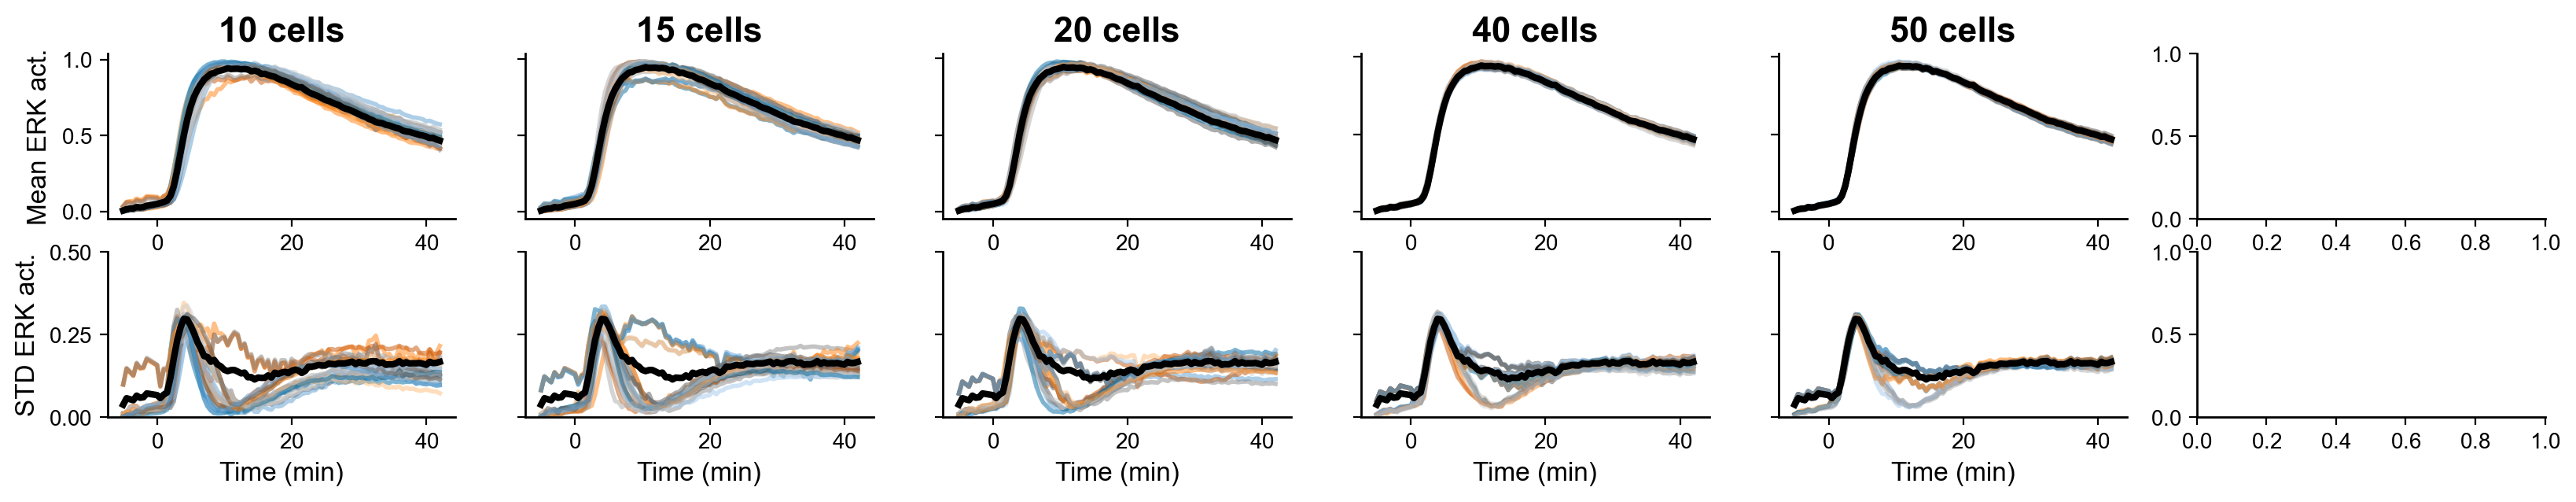

In [8]:
# how many traces do we have?
from scipy.stats import dunnett

# compute metric for each trace in the full dataset
times_40_idx = np.argmin(abs(times[:np.min(np.where(np.isnan(times)))]-40))
cyto_SAMs = np.apply_along_axis(sustained_activity_metric, axis=0, arr=normalized_C_noInhib, index_of_interest=times_40_idx)

ntimes, ncells = normalized_C_noInhib.shape

n_sets = 25

pvals = []

# for frac in [0.05, 0.1, 0.15, 0.25, 0.35, 0.5]:
fig, ax = plt.subplots(2,6, figsize=(20, 3))

for idx, size in enumerate([10,15,20,40,50,60]):
    # size = ncells*frac
    samples = []
    for i in range(n_sets):
        idxs = rng.choice(ncells, int(size), replace=False,)
        dat = normalized_C_noInhib[:,idxs]

        # compute the SAM for each sample
        sample_SAMs = np.apply_along_axis(sustained_activity_metric, axis=0, arr=dat, index_of_interest=times_40_idx)
        samples.append(np.array(sample_SAMs))

        # make a plot
        ax[0, idx].set_title('{} cells'.format(int(size)))
        ax[0, idx].plot(times, np.nanmean(dat, axis=1), linewidth=2, alpha=0.5)

        ax[1, idx].plot(times, np.nanstd(dat, axis=1), linewidth=2, alpha=0.5)
        ax[1, idx].set_xlabel('Time (min)')

        if idx == 0:
            ax[0, idx].set_ylabel('Mean ERK act.')
            ax[1, idx].set_ylabel('STD ERK act.')
       
        else:
            ax[0, idx].set_yticklabels([])
            ax[1, idx].set_yticklabels([])
        ax[0, idx].set_yticks([0.0, 0.5, 1.0])
        ax[1, idx].set_yticks([0.0, 0.25, 0.5])
        ax[1, idx].set_ylim([0.0, 0.5])

    ax[0, idx].plot(times, cyto_mean,  color='k', linewidth=3)
    ax[1, idx].plot(times, cyto_std,  color='k', linewidth=3)
    
    # now compute the p-value for each sample compared to pop mean
    res = dunnett(*samples, control=cyto_SAMs, alternative='two-sided')
    pvals.append(res.pvalue)

In [49]:
from math import comb

total = 0
for idx, size in enumerate([5,10,15,20,40,50]):
    temp =  comb(ncells, size)
    total += temp
    print(size,temp)

print('There are a total of {:.2e} possible combinations'.format(total))

5 18474840
10 954526728530
15 2840671544105280
20 1090013712241956540
40 6212195276963285554210
50 153720368566435227528
There are a total of 6.37e+21 possible combinations


Plasma Membrane

6


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_48638/966837240.py:16: RuntimeWarning: Mean of empty slice
  PM_mean = np.nanmean(normalized_D_noInhib, axis=1)
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


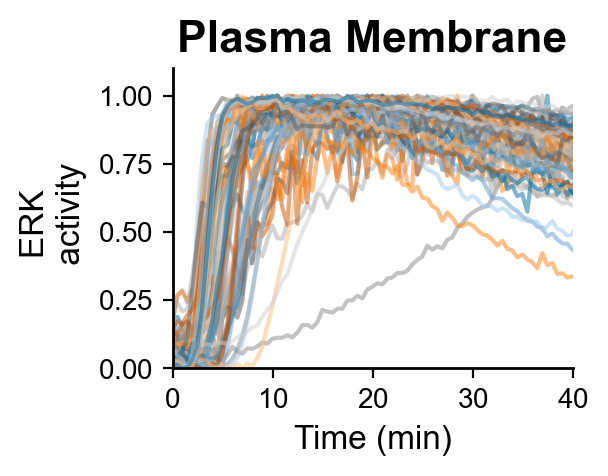

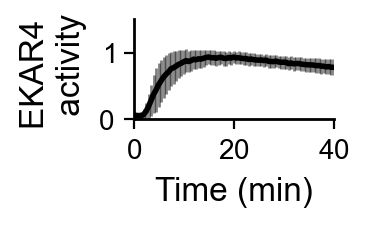

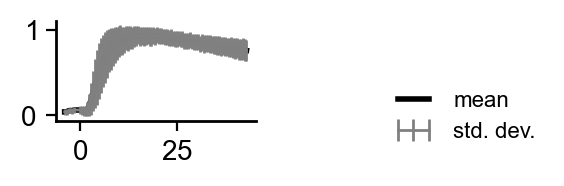

In [7]:
times = df_1D['Time (min)'].to_numpy()
times_D = times.copy()
filtered_columns = [col for col in df_1D.columns if 'Cell' in col and '.1' not in col]
D_noInhib = df_1D[filtered_columns].to_numpy()

# normalize each cell's response
normalize = lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x))
normalized_D_noInhib = np.apply_along_axis(normalize, axis=0, arr=D_noInhib)

T0_idx = np.where(times==0)[0][0]
print(T0_idx)

# save to numpy
np.savez('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-PM_normalized.npz', data=normalized_D_noInhib[T0_idx:np.min(np.where(np.isnan(times)))], time=times[T0_idx:np.min(np.where(np.isnan(times)))])

PM_mean = np.nanmean(normalized_D_noInhib, axis=1)
PM_std = np.nanstd(normalized_D_noInhib, axis=1)

fig, ax = get_sized_fig_ax(2.0, 1.5)
ax.plot(times, normalized_D_noInhib, alpha=0.5)
# ax.errorbar(times, PM_mean, yerr=PM_std, color='k', linewidth=1)
# ax.plot(times, PM_mean,  color='k', linewidth=3)
# ax.plot([times[T0_idx]]*2, [0,1], color='r', linewidth=3)
ax.set_xlabel('Time (min)')
ax.set_ylabel('ERK \n activity')
ax.set_title('Plasma Membrane')
ax.set_xlim([0, 40])
ax.set_ylim([0, 1.1])

fig.savefig('../../results/MAPK/param_est/Keyes_et_al_2020-fig1-data1-v2-PM.pdf', bbox_inches='tight', transparent=True)

fig, ax = get_sized_fig_ax(1.0, 0.5)

# rect = Rectangle((30, 0), 9.5, 1, facecolor='r', edgecolor='r', linewidth=1, alpha=0.25)
# ax.add_patch(rect)

# rect = Rectangle((30, 0), 10, 1, facecolor='none', edgecolor='r', linewidth=1)
# ax.add_patch(rect)

# ax.plot(times[:idx_10_min], normalized_D_noInhib[:idx_10_min], alpha=0.5)
# ax.errorbar(times[:idx_10_min], PM_mean[:idx_10_min], yerr=PM_std[:idx_10_min], color='k', linewidth=1, alpha=0.5)
# ax.plot(times[:idx_10_min], PM_mean[:idx_10_min],  color='k', linewidth=2)
ax.errorbar(times, PM_mean, yerr=PM_std, color='k', linewidth=1, alpha=0.5)
ax.plot(times, PM_mean,  color='k', linewidth=2)

# ax.plot([times[T0_idx]]*2, [0,1], color='r', linewidth=3)
ax.set_xlabel('Time (min)')
ax.set_ylabel('EKAR4 \n activity')
# ax.set_title('Cytoplasm')
ax.set_xticks([0, 20, 40])
ax.set_xlim([0, 40])
ax.set_ylim([0, 1.5])

fig.savefig('../../results/MAPK/param_est/Keyes_et_al_2020-fig1-data1-v2-PM-40min-noTraces_noBox.pdf', bbox_inches='tight', transparent=True)

# figure legend
fig, ax = get_sized_fig_ax(1.0, 0.5)
ax.plot(times, PM_mean,  color='k', linewidth=2)
ax.errorbar(times, PM_mean, yerr=PM_std, color='gray', linewidth=1, alpha=1.0)

leg = ax.legend(['mean', 'std. dev.'], fontsize=8.0, bbox_to_anchor=(2.5, 0.5))
export_legend(leg, filename='../../results/MAPK/param_est/Keyes_et_al_2020-fig1-data1-v2-PM-legend.pdf')


# fig.savefig('../../results/MAPK/param_est/Keyes_et_al_2020-fig1-data1-v2-CYTO-10min.pdf', bbox_inches='tight', transparent=True)


# save data
df = pd.DataFrame({'stimulus': input, 'response': PM_mean[T0_idx:], 'time': times[T0_idx:], 'response_std': PM_std[T0_idx:]})
df.to_csv('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-PM.csv', index=False)

# convert times to seconds and save as json
data = {'stimulus': [input], 'response': list(PM_mean[T0_idx:np.min(np.where(np.isnan(times)))]), 'time': list(times[T0_idx:np.min(np.where(np.isnan(times)))]*60), 'response_std': list(PM_std[T0_idx:np.min(np.where(np.isnan(times)))])}
with open('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-PM.json','w') as data_file:
    json.dump(data, data_file)

# Create dataset that end at 30 minutes and 10 mins
idx_30_min = np.argmin(abs(times[:np.min(np.where(np.isnan(times)))]-30))
idx_20_min = np.argmin(abs(times[:np.min(np.where(np.isnan(times)))]-20))
idx_10_min = np.argmin(abs(times[:np.min(np.where(np.isnan(times)))]-10))

# 30 mins
data = {'stimulus': [input], 'response': list(PM_mean[T0_idx:idx_30_min]), 'time': list(times[T0_idx:idx_30_min]*60), 'response_std': list(PM_std[T0_idx:idx_30_min])}
with open('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-PM-30min.json','w') as data_file:
    json.dump(data, data_file)

# 20 mins
data = {'stimulus': [input], 'response': list(PM_mean[T0_idx:idx_20_min]), 'time': list(times[T0_idx:idx_20_min]*60), 'response_std': list(PM_std[T0_idx:idx_20_min])}
with open('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-PM-20min.json','w') as data_file:
    json.dump(data, data_file)

 # 10 mins
data = {'stimulus': [input], 'response': list(PM_mean[T0_idx:idx_10_min]), 'time': list(times[T0_idx:idx_10_min]*60), 'response_std': list(PM_std[T0_idx:idx_10_min])}
with open('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-PM-10min.json','w') as data_file:
    json.dump(data, data_file)

dat = normalized_D_noInhib[T0_idx:np.min(np.where(np.isnan(times)))]
SAM40_pm = np.apply_along_axis(sustained_activity_metric, 0, dat, -1)

In [8]:
# save SAM40s
SAM40s = {'cyto': list(SAM40_cyto), 'pm': list(SAM40_pm)}
with open('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-SAM40s.json','w') as data_file:
    json.dump(SAM40s, data_file)

Now for the Rap1 inhibition data

There are two ways we can normalize the data:
1) To the max in each compartment
2) To the max in the whole dataset

First try way 1

In [16]:
print()


1.2431242330985914
1.38845849


In [10]:
pm_RAP1 = pd.read_excel('../../results/MAPK/Keyes_et_al_2020-fig3-data1-v2.xlsx', sheet_name='Figure 3C', skiprows=2)
cyto_RAP1 = pd.read_excel('../../results/MAPK/Keyes_et_al_2020-fig3-data1-v2.xlsx', sheet_name='Figure 3D', skiprows=2)

### Normalize to max in each compartment ###
# PM
filtered_columns = [col for col in pm_RAP1.columns if 'Cell' in col]
PM_RAP1 = pm_RAP1[filtered_columns].to_numpy()
times_f3C = pm_RAP1['Time (Min)'].to_numpy()

PM_min = 1.0 #np.nanmin([np.nanmin(D_noInhib), np.nanmin(PM_RAP1)])
# PM_max = np.nanmax([np.nanmax(D_noInhib), np.nanmax(PM_RAP1)])
PM_max = np.nanmax([np.nanmean(np.nanmax(D_noInhib, axis=0)), np.nanmean(np.nanmax(PM_RAP1, axis=0))])

# normalize_PM = lambda x: (x - np.nanmin([np.nanmin(D_noInhib), np.nanmin(PM_RAP1)])) #/ (np.nanmax(D_noInhib) - np.nanmin([np.nanmin(D_noInhib), np.nanmin(PM_RAP1)]))
normalize_PM = lambda x: (x - PM_min) / (PM_max - PM_min)

normalized_PM = np.apply_along_axis(normalize_PM, axis=0, arr=D_noInhib)
normalized_PM_RAP1 = np.apply_along_axis(normalize_PM, axis=0, arr=PM_RAP1)

# save to numpy
T0_idx = np.where(times_D==0)[0][0]
std = list(np.nanstd(normalized_PM, axis=1)[T0_idx:np.min(np.where(np.isnan(times_D)))]/2)
std[0] = 1e-15

# convert times to seconds and save as json
data = {'stimulus': [input], 
        'response': list(np.nanmean(normalized_PM, axis=1)[T0_idx:np.min(np.where(np.isnan(times_D)))]), 
        'time': list(times_D[T0_idx:np.min(np.where(np.isnan(times_D)))]*60), 
        'response_std': std}
with open('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-PM_PMmax.json','w') as data_file:
    json.dump(data, data_file)

# convert times to seconds and save as json
T0_idx = np.where(times_f3C==0)[0][0]
std = list(np.nanstd(normalized_PM_RAP1, axis=1)[T0_idx:np.argmin(np.abs(times_f3C-42))]/2)
std[0] = 1e-15
data = {'stimulus': [input], 
        'response': list(np.nanmean(normalized_PM_RAP1, axis=1)[T0_idx:np.argmin(np.abs(times_f3C-42))]), 
        'time': list(times_f3C[T0_idx:np.argmin(np.abs(times_f3C-42))]*60), 
        'response_std': std}
with open('../../results/MAPK/Keyes_et_al_2020-fig3-data1-v2-PM_RAP1inhib_PMmax.json','w') as data_file:
    json.dump(data, data_file)

# Cyto

filtered_columns = [col for col in cyto_RAP1.columns if 'Cell' in col]
CYTO_RAP1 = cyto_RAP1[filtered_columns].to_numpy()
times_f3D = cyto_RAP1['Time (Min)'].to_numpy()


CYTO_min = 1.0 #np.nanmin([np.nanmin(C_noInhib), np.nanmin(CYTO_RAP1)])
# CYTO_max = np.nanmax([np.nanmax(C_noInhib), np.nanmax(CYTO_RAP1)])
CYTO_max = np.nanmax([np.nanmean(np.nanmax(C_noInhib, axis=0)), np.nanmean(np.nanmax(CYTO_RAP1, axis=0))])

normalize_CYTO = lambda x: (x - CYTO_min) / (CYTO_max - CYTO_min)
normalized_CYTO = np.apply_along_axis(normalize_CYTO, axis=0, arr=C_noInhib)
normalized_CYTO_RAP1 = np.apply_along_axis(normalize_CYTO, axis=0, arr=CYTO_RAP1)

# convert times to seconds and save as json
T0_idx = np.where(times_C==0)[0][0]
std = list(np.nanstd(normalized_CYTO, axis=1)[T0_idx:np.min(np.where(np.isnan(times_C)))]/2)
std[0] = 1e-15

data = {'stimulus': [input], 
        'response': list(np.nanmean(normalized_CYTO, axis=1)[T0_idx:np.min(np.where(np.isnan(times_C)))]), 
        'time': list(times_C[T0_idx:np.min(np.where(np.isnan(times_C)))]*60), 
        'response_std': std}
with open('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-CYTO_CYTOmax.json','w') as data_file:
    json.dump(data, data_file)

# convert times to seconds and save as json
T0_idx = np.where(times_f3D==0)[0][0]
std = list(np.nanstd(normalized_CYTO_RAP1, axis=1)[T0_idx:np.argmin(np.abs(times_f3D-42))]/2)
std[0] = 1e-15

data = {'stimulus': [input], 
        'response': list(np.nanmean(normalized_CYTO_RAP1, axis=1)[T0_idx:np.argmin(np.abs(times_f3D-42))]), 
        'time': list(times_f3D[T0_idx:np.argmin(np.abs(times_f3D-42))]*60), 
        'response_std': std}
with open('../../results/MAPK/Keyes_et_al_2020-fig3-data1-v2-CYTO_RAP1inhib_CYTOmax.json','w') as data_file:
    json.dump(data, data_file)


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_48638/4018856793.py:27: RuntimeWarning: Mean of empty slice
  'response': list(np.nanmean(normalized_PM, axis=1)[T0_idx:np.min(np.where(np.isnan(times_D)))]),


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_7236/2682060208.py:8: RuntimeWarning: Mean of empty slice
  ax.errorbar(times_D, np.nanmean(normalized_PM, axis=1), yerr=np.nanstd(normalized_PM, axis=1)/2, linewidth=1, color='k')
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<ErrorbarContainer object of 3 artists>

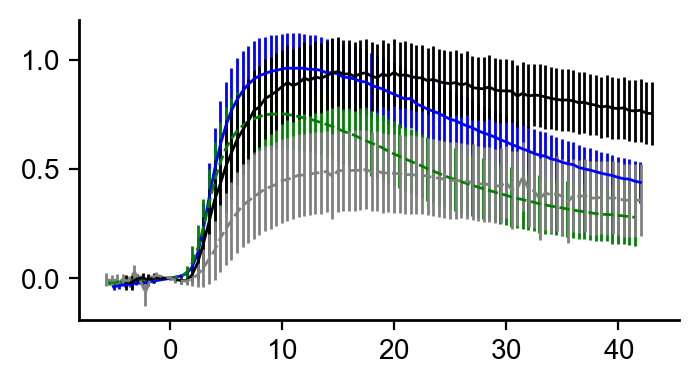

In [28]:
fig, ax = get_sized_fig_ax(3.0, 1.5)

ax.errorbar(times_C, np.nanmean(normalized_CYTO, axis=1), yerr=np.nanstd(normalized_CYTO, axis=1)/2, linewidth=1, color='b')
# ax.errorbar(times_C, np.nanmean(normalized_C_noInhib, axis=1), yerr=np.nanstd(normalized_C_noInhib, axis=1), linewidth=1, color='g')

ax.errorbar(times_f3D, np.nanmean(normalized_CYTO_RAP1, axis=1),  yerr=np.nanstd(normalized_CYTO_RAP1, axis=1)/2, linewidth=1, color='g', linestyle='--')

ax.errorbar(times_D, np.nanmean(normalized_PM, axis=1), yerr=np.nanstd(normalized_PM, axis=1)/2, linewidth=1, color='k')
# ax.errorbar(times_D, np.nanmean(normalized_D_noInhib, axis=1), yerr=np.nanstd(normalized_D_noInhib, axis=1), linewidth=1, color='k')
ax.errorbar(times_f3C, np.nanmean(normalized_PM_RAP1, axis=1),  yerr=np.nanstd(normalized_PM_RAP1, axis=1)/2, linewidth=1, color='gray', linestyle='--')

In [24]:
np.nanstd(normalized_CYTO, axis=1)

array([0.02850638, 0.02635381, 0.02546676, 0.02254747, 0.0213839 ,
       0.01874343, 0.01888875, 0.01795449, 0.01237941, 0.0119565 ,
       0.01725976, 0.03292972, 0.08113731, 0.14879104, 0.23523937,
       0.3246801 , 0.38482986, 0.40510623, 0.40160387, 0.39152441,
       0.37935994, 0.36911447, 0.35422483, 0.349658  , 0.34116221,
       0.33913077, 0.33140623, 0.32899233, 0.32466098, 0.31879351,
       0.32111769, 0.31937605, 0.31675582, 0.31371347, 0.31177245,
       0.31034538, 0.31007689, 0.30832089, 0.30555454, 0.30566612,
       0.30363731, 0.30337056, 0.30137249, 0.29967315, 0.29957622,
       0.29827983, 0.29450482, 0.29275292, 0.29090293, 0.29121716,
       0.28641146, 0.26765104, 0.2804888 , 0.28203284, 0.27853393,
       0.2761513 , 0.2736733 , 0.27001636, 0.26842225, 0.26720891,
       0.26341677, 0.26073882, 0.25733642, 0.25410092, 0.25063955,
       0.24855169, 0.24632639, 0.24291612, 0.24124655, 0.23743461,
       0.23349805, 0.23123742, 0.23121876, 0.22511265, 0.22392

Now way 2

In [168]:
### Normalize to global max ###
# PM
filtered_columns = [col for col in pm_RAP1.columns if 'Cell' in col]
PM_RAP1 = pm_RAP1[filtered_columns].to_numpy()
times_f3C = pm_RAP1['Time (Min)'].to_numpy()

g_min = 1.0 
g_max = np.nanmax([np.nanmax(D_noInhib), np.nanmax(PM_RAP1), np.nanmax(C_noInhib), np.nanmax(CYTO_RAP1)])
normalize = lambda x: (x - g_min) / (g_max - g_min)


normalized_PM = np.apply_along_axis(normalize, axis=0, arr=D_noInhib)
normalized_PM_RAP1 = np.apply_along_axis(normalize, axis=0, arr=PM_RAP1)

T0_idx = np.where(times_D==0)[0][0]
# convert times to seconds and save as json
std = list(np.nanstd(normalized_PM, axis=1)[T0_idx:np.min(np.where(np.isnan(times_D)))])
std[0] = 1e-15
data = {'stimulus': [input], 
        'response': list(np.nanmean(normalized_PM, axis=1)[T0_idx:np.min(np.where(np.isnan(times_D)))]), 
        'time': list(times_D[T0_idx:np.min(np.where(np.isnan(times_D)))]*60), 
        'response_std': std}
with open('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-PM_Gmax.json','w') as data_file:
    json.dump(data, data_file)

# convert times to seconds and save as json
T0_idx = np.where(times_f3C==0)[0][0]
data = {'stimulus': [input], 
        'response': list(np.nanmean(normalized_PM_RAP1, axis=1)[T0_idx:np.argmin(np.abs(times_f3C-42))]), 
        'time': list(times_f3C[T0_idx:np.argmin(np.abs(times_f3C-42))]*60), 
        'response_std': list(np.nanstd(normalized_PM_RAP1, axis=1)[T0_idx:np.argmin(np.abs(times_f3C-42))])}
with open('../../results/MAPK/Keyes_et_al_2020-fig3-data1-v2-PM_RAP1inhib_Gmax.json','w') as data_file:
    json.dump(data, data_file)

# Cyto
filtered_columns = [col for col in cyto_RAP1.columns if 'Cell' in col]
CYTO_RAP1 = cyto_RAP1[filtered_columns].to_numpy()
times_f3D = cyto_RAP1['Time (Min)'].to_numpy()
normalized_CYTO = np.apply_along_axis(normalize, axis=0, arr=C_noInhib)
normalized_CYTO_RAP1 = np.apply_along_axis(normalize, axis=0, arr=CYTO_RAP1)

# convert times to seconds and save as json
T0_idx = np.where(times_C==0)[0][0]
std = list(np.nanstd(normalized_CYTO, axis=1)[T0_idx:np.min(np.where(np.isnan(times_C)))])
std[0] = 1e-15

data = {'stimulus': [input], 
        'response': list(np.nanmean(normalized_CYTO, axis=1)[T0_idx:np.min(np.where(np.isnan(times_C)))]), 
        'time': list(times_C[T0_idx:np.min(np.where(np.isnan(times_C)))]*60), 
        'response_std': std}
with open('../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-CYTO_Gmax.json','w') as data_file:
    json.dump(data, data_file)

# convert times to seconds and save as json
T0_idx = np.where(times_f3D==0)[0][0]
data = {'stimulus': [input], 
        'response': list(np.nanmean(normalized_CYTO_RAP1, axis=1)[T0_idx:np.argmin(np.abs(times_f3D-42))]), 
        'time': list(times_f3D[T0_idx:np.argmin(np.abs(times_f3D-42))]*60), 
        'response_std': list(np.nanstd(normalized_CYTO_RAP1, axis=1)[T0_idx:np.argmin(np.abs(times_f3D-42))])}
with open('../../results/MAPK/Keyes_et_al_2020-fig13data1-v2-CYTO_RAP1inhib_Gmax.json','w') as data_file:
    json.dump(data, data_file)

/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_84111/3638505406.py:20: RuntimeWarning: Mean of empty slice
  'response': list(np.nanmean(normalized_PM, axis=1)[T0_idx:np.min(np.where(np.isnan(times_D)))]),


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_84111/3644939328.py:7: RuntimeWarning: Mean of empty slice
  ax.errorbar(times_D, np.nanmean(normalized_PM, axis=1), yerr=np.nanstd(normalized_PM, axis=1), linewidth=1, color='k')
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<ErrorbarContainer object of 3 artists>

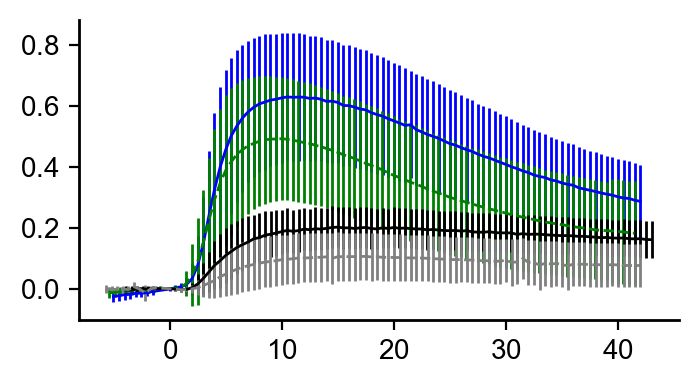

In [163]:
fig, ax = get_sized_fig_ax(3.0, 1.5)
ax.errorbar(times_C, np.nanmean(normalized_CYTO, axis=1), yerr=np.nanstd(normalized_CYTO, axis=1), linewidth=1, color='b')
# ax.errorbar(times_C, np.nanmean(normalized_C_noInhib, axis=1), yerr=np.nanstd(normalized_C_noInhib, axis=1), linewidth=1, color='g')

ax.errorbar(times_f3D, np.nanmean(normalized_CYTO_RAP1, axis=1),  yerr=np.nanstd(normalized_CYTO_RAP1, axis=1), linewidth=1, color='g', linestyle='--')

ax.errorbar(times_D, np.nanmean(normalized_PM, axis=1), yerr=np.nanstd(normalized_PM, axis=1), linewidth=1, color='k')
# ax.errorbar(times_D, np.nanmean(normalized_D_noInhib, axis=1), yerr=np.nanstd(normalized_D_noInhib, axis=1), linewidth=1, color='k')
ax.errorbar(times_f3C, np.nanmean(normalized_PM_RAP1, axis=1),  yerr=np.nanstd(normalized_PM_RAP1, axis=1), linewidth=1, color='gray', linestyle='--')

In [173]:
print(len(times_f3D))

94
